<h2>Solving Sudoku using Gradient Boosting Classfier<h2>

<h3>What is Sudoku?</h3>

From Wikipedia:

<em>"Sudoku, originally called Number Place) is a logic-based, combinatorial number-placement puzzle. The objective is to fill a 9×9 grid with digits so that each column, each row, and each of the nine 3×3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9."</em>

<h3>Model Description</h3>

In this notebook I am attempting to formulate a semi-machine learning model that can predict the value of a particular cell of the puzzle.

The dataset for training is obtained from Kaggle : https://www.kaggle.com/bryanpark/sudoku

I am training a classifier whose input contains 26 features and output is a single value, the value of predicted cell. The 26 features consist of 8 values in same row, 8 values in same column, 8 values in same box, and 2 values which indicate position of the cell in the puzzle(row,column). For training, data is taken from 1000 puzzles and their solutions. It is split in a ratio 9:1, and 1 part is used as dev set. The data is further tested on 5000 examples. For improving accuracy, the output is fitted into puzzle and given as input again till further predictions make no change.

The classifier used is Gradient Boosting Classifier, and learning rate chosen is 0.1. Accuracy is defined as no. of correct predictions out of no. of blank spaces. The model gave an accuracy of 73% on dev set.(With output not fitted into input).

<h3>Acknowledgements</h3>

I am grateful to Bryan Park for sharing this dataset.
https://www.kaggle.com/bryanpark/sudoku

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import os

In [2]:
#Importing Dataset
sudoku = pd.read_csv('sudoku.csv')

In [3]:
#Preview of Data
sudoku.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


<strong>Here I am using the code provided in the Kaggle Dataset page for converting the data to numpy arrays</strong>

In [4]:
quizzes = np.zeros((1000000, 81), np.int32)
solutions = np.zeros((1000000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        quizzes[i, j] = q
        solutions[i, j] = s
quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

In [5]:
#Sample Puzzle
print(quizzes[0])

[[0 0 4 3 0 0 2 0 9]
 [0 0 5 0 0 9 0 0 1]
 [0 7 0 0 6 0 0 4 3]
 [0 0 6 0 0 2 0 8 7]
 [1 9 0 0 0 7 4 0 0]
 [0 5 0 0 8 3 0 0 0]
 [6 0 0 0 0 0 1 0 5]
 [0 0 3 5 0 8 6 9 0]
 [0 4 2 9 1 0 3 0 0]]


In [6]:
#Sample Solution
print(solutions[0])

[[8 6 4 3 7 1 2 5 9]
 [3 2 5 8 4 9 7 6 1]
 [9 7 1 2 6 5 8 4 3]
 [4 3 6 1 9 2 5 8 7]
 [1 9 8 6 5 7 4 3 2]
 [2 5 7 4 8 3 9 1 6]
 [6 8 9 7 3 4 1 2 5]
 [7 1 3 5 2 8 6 9 4]
 [5 4 2 9 1 6 3 7 8]]


<strong>The following code converts the data to the form described in model description</strong>

In [104]:
X = []
y = []

In [105]:
for p in range(1000):
    k = quizzes[p]
    m = solutions[p]
    for i in range(9):
        for j in range(9):
            temp = []
            value = m[i][j]
            for l in range(i):
                temp.append(k[l][j])
            for l in range(i+1,9):
                temp.append(k[l][j])
            for l in range(j):
                temp.append(k[i][l])
            for l in range(j+1,9):
                temp.append(k[i][l])
            temp.append(i)
            temp.append(j)
            
            if i<3 and j<3:
                for l in range(0,3):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
            elif i<3 and j<6:
                for l in range(0,3):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
            elif i<3 and j<9:
                for l in range(0,3):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
                
            elif i<6 and j<3:
                for l in range(3,6):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
            elif i<6 and j<6:
                for l in range(3,6):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
            elif i<6 and j<9:
                for l in range(3,6):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
                
            elif i<9 and j<3:
                for l in range(6,9):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
            elif i<9 and j<6:
                for l in range(6,9):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
            elif i<9 and j<9:
                for l in range(6,9):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                X.append(temp)
                y.append(value)
                
            
        for j in range(9):
            temp = []
            value = m[i][j]
            for l in range(i):
                temp.append(m[l][j])
            for l in range(i+1,9):
                temp.append(m[l][j])
            for l in range(j):
                temp.append(m[i][l])
            for l in range(j+1,9):
                temp.append(m[i][l])
            temp.append(i)
            temp.append(j)
            
            if i<3 and j<3:
                for l in range(0,3):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)
            elif i<3 and j<6:
                for l in range(0,3):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)
            elif i<3 and j<9:
                for l in range(0,3):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)
                
            elif i<6 and j<3:
                for l in range(3,6):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)
            elif i<6 and j<6:
                for l in range(3,6):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)
            elif i<6 and j<9:
                for l in range(3,6):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)
                
            elif i<9 and j<3:
                for l in range(6,9):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)
            elif i<9 and j<6:
                for l in range(6,9):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)
            elif i<9 and j<9:
                for l in range(6,9):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(m[l][r])
                        else:
                            if r!=j:
                                temp.append(m[l][r])
                X.append(temp)
                y.append(value)

In [106]:
X = np.asarray(X)
y = np.asarray(y)

In [18]:
#Shape of Input Array
X.shape

(162000, 26)

In [19]:
#Shape of output Array
y.shape

(162000,)

In [20]:
#Sample Input and Corresponding Output
print(X[0],y[0])

[0 0 0 1 0 6 0 0 0 4 3 0 0 2 0 9 0 0 0 4 0 0 5 0 7 0] 8


In [21]:
#Splitting data into training set and dev set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [22]:
#Training
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbc = GBC(learning_rate = 0.1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [23]:
#Predictions
y_pred = gbc.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [24]:
#Confusion Matrix
print(cm)

[[1058   34   48   59   81   80  110  129  191]
 [  23 1058   44   72   76   78  103  120  187]
 [  11   19 1139   57   86   73   96  127  166]
 [  18    9   18 1236   90   70   91  129  178]
 [   7    6    6   14 1219   85  118  132  191]
 [  14    7   22   29   34 1298  101  109  171]
 [  15    4    8   17   18   29 1415   99  187]
 [   4    1    1    9   15   11   35 1548  186]
 [   0    0    0    0    0    0    0    1 1870]]


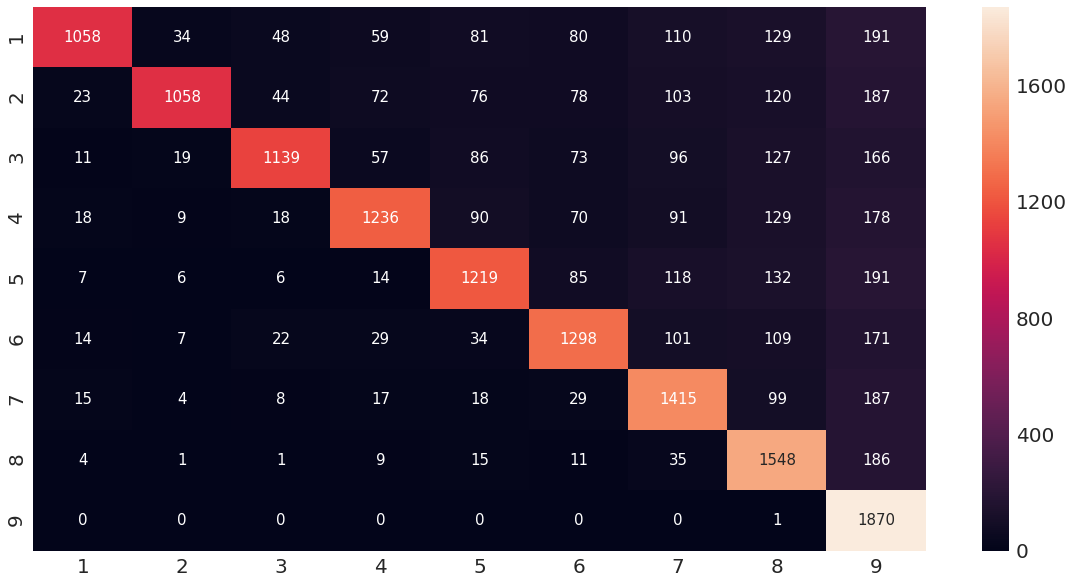

In [50]:
#Visualisation of Confusion Matrix
#Code Source : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
df_cm = pd.DataFrame(cm, index = [i for i in range(1,10)],
                  columns = [i for i in range(1,10)])
plt.figure(figsize = (20,10))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 15}, fmt = 'g')

The major limitation of the model is the tendency to predict higher values.

In [51]:
#Accuracy
s = 0
for i in range(9):
    for j in range(9):
        if i==j:
            s += cm[i][j]

In [52]:
print('Accuracy : ',"{0:.2f}".format(s/X_test.shape[0]*100),'%')

Accuracy :  73.09 %


<h2>Test Results</h2>

In [61]:
#Predictor to function to preprocess data and return prediction
def pred(k,i,j):
            temp = []
            for l in range(i):
                temp.append(k[l][j])
            for l in range(i+1,9):
                temp.append(k[l][j])
            for l in range(j):
                temp.append(k[i][l])
            for l in range(j+1,9):
                temp.append(k[i][l])
            temp.append(i)
            temp.append(j)
            
            if i<3 and j<3:
                for l in range(0,3):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
               
            elif i<3 and j<6:
                for l in range(0,3):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
               
            elif i<3 and j<9:
                for l in range(0,3):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                               
            elif i<6 and j<3:
                for l in range(3,6):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            elif i<6 and j<6:
                for l in range(3,6):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
               
            elif i<6 and j<9:
                for l in range(3,6):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
                
            elif i<9 and j<3:
                for l in range(6,9):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            elif i<9 and j<6:
                for l in range(6,9):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            elif i<9 and j<9:
                for l in range(6,9):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            temp = np.asarray(temp)
            temp = np.reshape(temp,(1,26))
            return gbc.predict(temp)

In [62]:
#Test Predictions for 4000 Puzzles(Ouput Not fitted Back to Input)
count = 0
acc = []
right_count = 0
blank = []
predicted = []
count_num = [0,0,0,0,0,0,0,0,0,0]
right = [0,0,0,0,0,0,0,0,0,0]
wrong = [0,0,0,0,0,0,0,0,0,0]
for p in range(1000,5000):
    count_arr = count
    right_arr = right_count
    y_pred = []
    k = quizzes[p]
    l = solutions[p]
    for i in range(9):
        tem = []
        for j in range(9):
            if k[i][j] == 0 and l[i][j] != 0:
                if l[i][j] == 1:
                    count_num[1]+=1
                elif l[i][j] == 2:
                    count_num[2]+=1
                elif l[i][j] == 3:
                    count_num[3]+=1
                elif l[i][j] == 4:
                    count_num[4]+=1
                elif l[i][j] == 5:
                    count_num[5]+=1
                elif l[i][j] == 6:
                    count_num[6]+=1
                elif l[i][j] == 7:
                    count_num[7]+=1
                elif l[i][j] == 8:
                    count_num[8]+=1
                elif l[i][j] == 9:
                    count_num[9]+=1
                count += 1
                prediction = pred(k,i,j)[0]
                if prediction == l[i][j]:
                    right_count += 1
                    if l[i][j] == 1:
                        right[1]+=1
                    elif l[i][j] == 2:
                        right[2]+=1
                    elif l[i][j] == 3:
                        right[3]+=1
                    elif l[i][j] == 4:
                        right[4]+=1
                    elif l[i][j] == 5:
                        right[5]+=1
                    elif l[i][j] == 6:
                        right[6]+=1
                    elif l[i][j] == 7:
                        right[7]+=1
                    elif l[i][j] == 8:
                        right[8]+=1
                    elif l[i][j] == 9:
                        right[9]+=1
                else:
                    if l[i][j] == 1:
                        wrong[1]+=1
                    elif l[i][j] == 2:
                        wrong[2]+=1
                    elif l[i][j] == 3:
                        wrong[3]+=1
                    elif l[i][j] == 4:
                        wrong[4]+=1
                    elif l[i][j] == 5:
                        wrong[5]+=1
                    elif l[i][j] == 6:
                        wrong[6]+=1
                    elif l[i][j] == 7:
                        wrong[7]+=1
                    elif l[i][j] == 8:
                        wrong[8]+=1
                    elif l[i][j] == 9:
                        wrong[9]+=1
                tem.append(prediction)
            else:
                tem.append(k[i][j])
        y_pred.append(tem)
    count_arr = count - count_arr
    right_arr = right_count - right_arr
    blank.append(count_arr)
    predicted.append(right_arr)
    acc.append((right_arr/count_arr)*100)
print(k)
print(l)
print(np.asarray(y_pred))
print('Predicted ',right_count,' out of ',count,' correctly.')
print('Accuracy : ','{0:.2f}'.format((right_count/count)*100),'%')
for i in range(1,10):
    print('Correct Predictions for ',i,' : ',right[i])
for i in range(1,10):
    print('Wrong Predictions for ',i,' : ',wrong[i])
for i in range(1,10):
    print('Accuracy for ',i,' : ','{0:.2f}'.format((right[i]/count_num[i])*100),'%')

[[0 3 0 9 0 0 1 0 0]
 [1 6 8 0 0 3 2 0 0]
 [5 0 0 0 0 0 0 6 0]
 [0 0 0 0 9 7 3 4 2]
 [0 0 6 5 8 0 0 0 0]
 [0 4 7 0 1 2 0 0 8]
 [0 8 5 2 3 0 0 0 9]
 [7 0 2 0 5 0 0 0 0]
 [0 0 0 8 0 1 0 0 4]]
[[2 3 4 9 6 5 1 8 7]
 [1 6 8 7 4 3 2 9 5]
 [5 7 9 1 2 8 4 6 3]
 [8 5 1 6 9 7 3 4 2]
 [3 2 6 5 8 4 9 7 1]
 [9 4 7 3 1 2 6 5 8]
 [4 8 5 2 3 6 7 1 9]
 [7 1 2 4 5 9 8 3 6]
 [6 9 3 8 7 1 5 2 4]]
[[4 3 4 9 7 8 1 8 7]
 [1 6 8 7 7 3 2 9 7]
 [5 9 9 7 7 8 9 6 7]
 [8 5 1 6 9 7 3 4 2]
 [9 9 6 5 8 4 9 9 7]
 [9 4 7 3 1 2 9 9 8]
 [6 8 5 2 3 6 7 7 9]
 [7 9 2 6 5 9 8 8 6]
 [9 9 9 8 7 1 7 7 4]]
Predicted  100349  out of  188705  correctly.
Accuracy :  53.18 %
Correct Predictions for  1  :  5965
Correct Predictions for  2  :  6006
Correct Predictions for  3  :  6938
Correct Predictions for  4  :  8712
Correct Predictions for  5  :  10747
Correct Predictions for  6  :  11021
Correct Predictions for  7  :  14026
Correct Predictions for  8  :  16062
Correct Predictions for  9  :  20872
Wrong Predictions for  1  :  15006


As seen the Confusion Matrix, the model produces better results for higher values

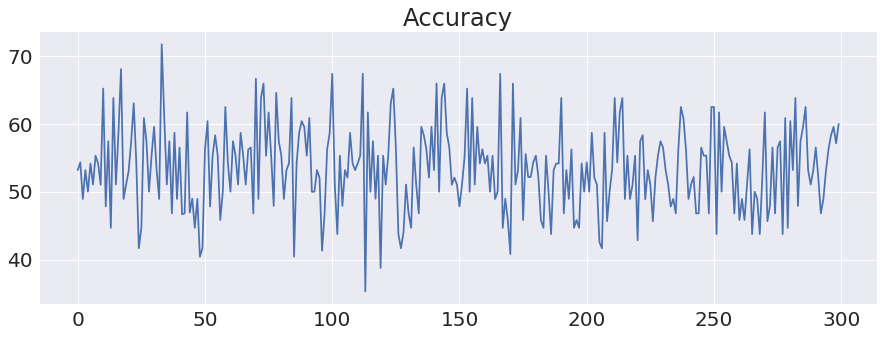

In [65]:
#Plot of Accuracy for first 300 test arrays
plt.figure(figsize = (15,5))
sn.set_style('darkgrid')
plt.plot(acc[:300])
plt.title('Accuracy')

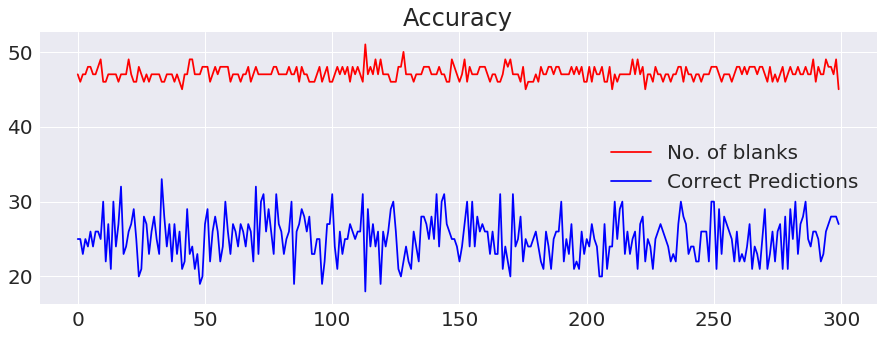

In [66]:
#Correct Predictions vs Number of blanks
plt.figure(figsize = (15,5))
plt.plot(blank[:300], color = 'red', label = 'No. of blanks')
plt.plot(predicted[:300], color = 'blue', label = 'Correct Predictions')
plt.legend()
plt.title('Accuracy')

In [68]:
#The Best and The Worst result
ma = 0
mi = 100
for i in range(len(acc)):
    if acc[i]>=ma:
        ma = acc[i]
        ma_i = 1000+i#Noting down index for future use
    if acc[i]<=mi:
        mi = acc[i]
        mi_i = 1000+i#Noting down index for future use
print('Highest accuracy attained is ',"{0:.2f}".format(ma),'%')
print('Lowest accuracy attained is ',"{0:.2f}".format(mi),'%')

Highest accuracy attained is  75.56 %
Lowest accuracy attained is  29.79 %


In [69]:
print('Puzzle which gave highest accuracy(','{0:.2f}'.format(ma),'%)')
print(quizzes[ma_i])

Puzzle which gave highest accuracy( 75.56 %)
[[0 0 0 2 5 7 0 0 0]
 [0 9 1 0 0 0 0 5 3]
 [0 4 2 1 0 0 0 0 6]
 [3 0 4 9 0 0 6 0 0]
 [8 7 0 0 0 6 4 0 1]
 [0 0 0 0 7 8 0 2 0]
 [0 6 0 5 3 0 1 0 8]
 [0 5 0 0 0 2 7 3 9]
 [4 0 9 0 8 0 0 0 0]]


In [71]:
#Preprocessing function
def loop(k,i,j):
            temp = []
            for l in range(i):
                temp.append(k[l][j])
            for l in range(i+1,9):
                temp.append(k[l][j])
            for l in range(j):
                temp.append(k[i][l])
            for l in range(j+1,9):
                temp.append(k[i][l])
            
            if i<3 and j<3:
                for l in range(0,3):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
            elif i<3 and j<6:
                for l in range(0,3):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
            
            elif i<3 and j<9:
                for l in range(0,3):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
                
            elif i<6 and j<3:
                for l in range(3,6):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            elif i<6 and j<6:
                for l in range(3,6):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            elif i<6 and j<9:
                for l in range(3,6):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
               
                
            elif i<9 and j<3:
                for l in range(6,9):
                    for r in range(0,3):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            elif i<9 and j<6:
                for l in range(6,9):
                    for r in range(3,6):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            elif i<9 and j<9:
                for l in range(6,9):
                    for r in range(6,9):
                        if l!= i:
                            temp.append(k[l][r])
                        else:
                            if r!=j:
                                temp.append(k[l][r])
                
            return temp

In [83]:
#Improving Accuracy by fitting output to input
for b in range(5):
    if b==0:
        new = np.copy(quizzes[ma_i])
    count = 0
    acc = []
    right_count = 0
    blank = []
    predicted = []
    count_num = [0,0,0,0,0,0,0,0,0,0]
    right = [0,0,0,0,0,0,0,0,0,0]
    wrong = [0,0,0,0,0,0,0,0,0,0]
    count_arr = count
    right_arr = right_count
    k = np.copy(new)
    l = solutions[ma_i]
    y_pred = np.copy(k)
    for i in range(9):
        tem = []
        for j in range(9):
            if k[i][j] == 0 or k[i][j] in loop(k,i,j):
                if l[i][j] == 1:
                    count_num[1]+=1
                elif l[i][j] == 2:
                    count_num[2]+=1
                elif l[i][j] == 3:
                    count_num[3]+=1
                elif l[i][j] == 4:
                    count_num[4]+=1
                elif l[i][j] == 5:
                    count_num[5]+=1
                elif l[i][j] == 6:
                    count_num[6]+=1
                elif l[i][j] == 7:
                    count_num[7]+=1
                elif l[i][j] == 8:
                    count_num[8]+=1
                elif l[i][j] == 9:
                    count_num[9]+=1
                
                count += 1
                prediction = pred(k,i,j)[0]
                loo = loop(k,i,j)
                #print(prediction,loo)
                if prediction not in loo:
                    tem.append(prediction)
                    k[i][j] = prediction
                    
                else:
                    tem.append(0)
                
                if prediction == l[i][j]:

                    right_count += 1
                    if l[i][j] == 1:
                        right[1]+=1
                    elif l[i][j] == 2:
                        right[2]+=1
                    elif l[i][j] == 3:
                        right[3]+=1
                    elif l[i][j] == 4:
                        right[4]+=1
                    elif l[i][j] == 5:
                        right[5]+=1
                    elif l[i][j] == 6:
                        right[6]+=1
                    elif l[i][j] == 7:
                        right[7]+=1
                    elif l[i][j] == 8:
                        right[8]+=1
                    elif l[i][j] == 9:
                        right[9]+=1
                else:
                    if l[i][j] == 1:
                        wrong[1]+=1
                    elif l[i][j] == 2:
                        wrong[2]+=1
                    elif l[i][j] == 3:
                        wrong[3]+=1
                    elif l[i][j] == 4:
                        wrong[4]+=1
                    elif l[i][j] == 5:
                        wrong[5]+=1
                    elif l[i][j] == 6:
                        wrong[6]+=1
                    elif l[i][j] == 7:
                        wrong[7]+=1
                    elif l[i][j] == 8:
                        wrong[8]+=1
                    elif l[i][j] == 9:
                        wrong[9]+=1
                    
            else:
                tem.append(k[i][j])
        y_pred[i] = np.copy(np.asarray(tem))
    new = np.copy(np.asarray(y_pred))

In [75]:
print('Predicted Array')
print(np.asarray(y_pred))
print('Correct Array')
print(l)

Predicted Array
[[6 8 3 2 5 7 9 4 0]
 [7 9 1 8 6 4 2 5 3]
 [5 4 2 1 9 3 8 7 6]
 [3 1 4 9 2 5 6 8 7]
 [8 7 5 3 0 6 4 9 1]
 [9 0 6 4 7 8 5 2 0]
 [2 6 7 5 3 9 1 0 8]
 [1 5 8 6 4 2 7 3 9]
 [4 3 9 7 8 1 0 6 5]]
Correct Array
[[6 8 3 2 5 7 9 1 4]
 [7 9 1 8 6 4 2 5 3]
 [5 4 2 1 9 3 8 7 6]
 [3 2 4 9 1 5 6 8 7]
 [8 7 5 3 2 6 4 9 1]
 [9 1 6 4 7 8 3 2 5]
 [2 6 7 5 3 9 1 4 8]
 [1 5 8 6 4 2 7 3 9]
 [4 3 9 7 8 1 5 6 2]]


In [76]:
b = 0
for i in range(9):
    for j in range(9):
        if quizzes[ma_i][i][j] == 0:
            b +=1
print('No. of blanks in input : ',b)

No. of blanks in input :  45


In [78]:
c = 0
for i in range(9):
    for j in range(9):
        if y_pred[i][j] == l[i][j] and quizzes[ma_i][i][j] == 0:
            c += 1
print('Correct predictions = ', c)
print('Accuracy : ','{0:.2f}'.format((c/b)*100),'%')

Correct predictions =  34
Accuracy :  75.56 %


<strong>For the Array with highest accuracy, there isn't any improvement in accuracy</strong>

In [85]:
print('Puzzle which gave lowest accuracy(','{0:.2f}'.format(mi),'%)')
print(quizzes[mi_i])

Puzzle which gave lowest accuracy( 29.79 %)
[[7 6 0 0 4 1 5 2 0]
 [0 0 0 2 6 8 0 7 0]
 [0 3 0 0 7 0 4 0 0]
 [0 7 0 0 0 0 0 0 3]
 [2 8 0 0 0 0 6 1 0]
 [0 0 3 0 2 9 0 5 7]
 [0 0 1 0 0 0 0 0 8]
 [0 0 5 4 3 7 0 6 0]
 [6 4 0 0 8 0 0 0 0]]


In [84]:
#Improving Accuracy by fitting output to input
for b in range(5):
    if b==0:
        new = np.copy(quizzes[mi_i])
    count = 0
    acc = []
    right_count = 0
    blank = []
    predicted = []
    count_num = [0,0,0,0,0,0,0,0,0,0]
    right = [0,0,0,0,0,0,0,0,0,0]
    wrong = [0,0,0,0,0,0,0,0,0,0]
    count_arr = count
    right_arr = right_count
    k = np.copy(new)
    l = solutions[mi_i]
    y_pred = np.copy(k)
    for i in range(9):
        tem = []
        for j in range(9):
            if k[i][j] == 0 or k[i][j] in loop(k,i,j):
                if l[i][j] == 1:
                    count_num[1]+=1
                elif l[i][j] == 2:
                    count_num[2]+=1
                elif l[i][j] == 3:
                    count_num[3]+=1
                elif l[i][j] == 4:
                    count_num[4]+=1
                elif l[i][j] == 5:
                    count_num[5]+=1
                elif l[i][j] == 6:
                    count_num[6]+=1
                elif l[i][j] == 7:
                    count_num[7]+=1
                elif l[i][j] == 8:
                    count_num[8]+=1
                elif l[i][j] == 9:
                    count_num[9]+=1
                count += 1
                prediction = pred(k,i,j)[0]
                loo = loop(k,i,j)
                #print(prediction,loo)
                if prediction not in loo:
                    tem.append(prediction)
                    k[i][j] = prediction
                else:
                    tem.append(0)
                if prediction == l[i][j]:

                    right_count += 1
                    if l[i][j] == 1:
                        right[1]+=1
                    elif l[i][j] == 2:
                        right[2]+=1
                    elif l[i][j] == 3:
                        right[3]+=1
                    elif l[i][j] == 4:
                        right[4]+=1
                    elif l[i][j] == 5:
                        right[5]+=1
                    elif l[i][j] == 6:
                        right[6]+=1
                    elif l[i][j] == 7:
                        right[7]+=1
                    elif l[i][j] == 8:
                        right[8]+=1
                    elif l[i][j] == 9:
                        right[9]+=1
                else:
                    if l[i][j] == 1:
                        wrong[1]+=1
                    elif l[i][j] == 2:
                        wrong[2]+=1
                    elif l[i][j] == 3:
                        wrong[3]+=1
                    elif l[i][j] == 4:
                        wrong[4]+=1
                    elif l[i][j] == 5:
                        wrong[5]+=1
                    elif l[i][j] == 6:
                        wrong[6]+=1
                    elif l[i][j] == 7:
                        wrong[7]+=1
                    elif l[i][j] == 8:
                        wrong[8]+=1
                    elif l[i][j] == 9:
                        wrong[9]+=1

            else:
                tem.append(k[i][j])
        y_pred[i] = np.copy(np.asarray(tem))
    new = np.copy(np.asarray(y_pred))

In [80]:
print('Predicted Array')
print(np.asarray(y_pred))
print('Correct Array')
print(l)

Predicted Array
[[7 6 9 3 4 1 5 2 0]
 [5 1 4 2 6 8 9 7 0]
 [8 3 2 9 7 5 4 0 6]
 [9 7 6 8 1 4 2 0 3]
 [2 8 0 7 5 3 6 1 9]
 [4 0 3 6 2 9 8 5 7]
 [3 9 1 5 0 6 7 4 8]
 [0 2 5 4 3 7 1 6 0]
 [6 4 7 1 8 2 3 9 5]]
Correct Array
[[7 6 8 3 4 1 5 2 9]
 [9 5 4 2 6 8 3 7 1]
 [1 3 2 9 7 5 4 8 6]
 [5 7 6 8 1 4 2 9 3]
 [2 8 9 7 5 3 6 1 4]
 [4 1 3 6 2 9 8 5 7]
 [3 2 1 5 9 6 7 4 8]
 [8 9 5 4 3 7 1 6 2]
 [6 4 7 1 8 2 9 3 5]]


In [81]:
b = 0
for i in range(9):
    for j in range(9):
        if quizzes[mi_i][i][j] == 0:
            b +=1
print('No. of blanks in input : ',b)

No. of blanks in input :  47


In [82]:
c = 0
for i in range(9):
    for j in range(9):
        if y_pred[i][j] == l[i][j] and quizzes[mi_i][i][j] == 0:
            c += 1
print('Correct predictions = ', c)
print('Accuracy : ','{0:.2f}'.format((c/b)*100),'%')

Correct predictions =  27
Accuracy :  57.45 %


<strong>Here the accuracy is improved from 30% to 57% with new method.</strong>